In [1]:
import jax
import jax.numpy as jnp
import numpyro
from numpyro import handlers
import numpyro.distributions as dist
from numpyro.infer import (
    Predictive,
    SVI,
    TraceMeanField_ELBO,
    autoguide,
    init_to_feasible,
)
from helper import make_bmlp_model, construct_normal_prior, generate_data_v2

import inspeqtor.experimental as sq
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import arviz as az

## Introduction

In this notebook, we will do the following:
- Generate the noisy data as always
- Use BNN to fit the data
- Visualize the results
- Usnig the pre-trained BNN in another opitmization problem
- Visualize the results of the second optimization problem

> This is the proof of concept of how to use BNN to do the optimization problem for the quantum optimal control problem. 

## Generate noisy data for our experiment!

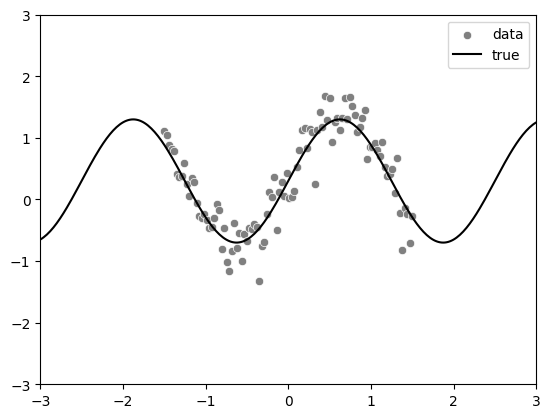

In [58]:
std = 0.25
true_fn, noise_fn = generate_data_v2(s=std)
x_range = jnp.linspace(-1.5, 1.5, 100)
x_test = jnp.linspace(-3.0, 3.0, num=300).reshape(-1, 1)

key = jax.random.key(0)
key, subkey = jax.random.split(key)

y_noise = noise_fn(x_range, subkey)


def plot_data():
    fig, ax = plt.subplots()

    _ = sns.scatterplot(
        x=np.asarray(x_range), y=np.asarray(y_noise), ax=ax, color="gray", label="data"
    )
    _ = sns.lineplot(
        x=np.asarray(x_test).reshape(-1),
        y=np.asarray(true_fn(x_test)).reshape(-1),
        ax=ax,
        label="true",
        color="black",
    )

    ax.set_ylim(-3.0, 3.0)
    ax.set_xlim(x_test[0].item(), x_test[-1].item())

    return fig, ax


fig, ax = plot_data()

## Perform the inference for BNN using the data

In [107]:
n_iterations = 10000
optimizer = sq.optimize.get_default_optimizer(n_iterations=n_iterations)

key = jax.random.key(2)
key, subkey = jax.random.split(key)

model = make_bmlp_model([5], use_bayesian=True, sigma_prior=dist.LogNormal(0.25, 1.25))
guide = autoguide.AutoDiagonalNormal(model, init_loc_fn=init_to_feasible)

svi = SVI(
    model,
    guide,
    numpyro.optim.optax_to_numpyro(optimizer),
    TraceMeanField_ELBO(),
)

svi_result = svi.run(
    rng_key=subkey,
    num_steps=int(n_iterations * 1.2),
    x=x_range.reshape(-1, 1),
    y=y_noise,
    progress_bar=True,
)

100%|██████████| 12000/12000 [00:01<00:00, 7539.43it/s, init loss: 152.9168, avg. loss [11401-12000]: 81.3352]


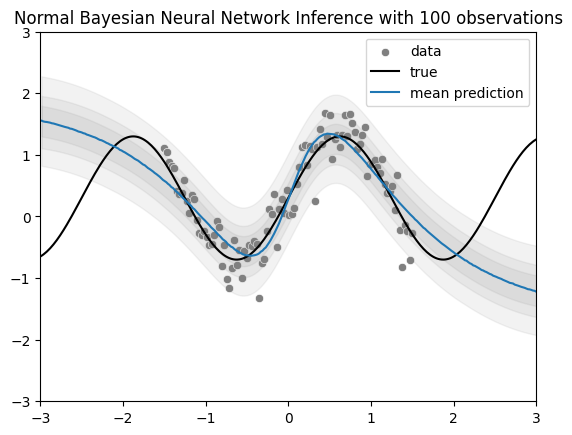

In [108]:
# plot the results
key, subkey = jax.random.split(key)
y_pred = Predictive(model, guide=guide, params=svi_result.params, num_samples=20_000)(
    subkey,
    x=x_test,
)["y"]


def plot_bnn(ax):
    for hdi_prob in [
        0.5,
        0.75,
        0.95,
    ]:
        _ = az.plot_hdi(
            x=x_test.reshape(-1),
            y=jnp.expand_dims(y_pred, axis=0),
            hdi_prob=hdi_prob,
            fill_kwargs={"alpha": 0.1},
            color="gray",
            ax=ax,
        )

    _ = sns.lineplot(
        x=np.asarray(x_test).reshape(-1),
        y=np.asarray(jnp.mean(y_pred, axis=0)),
        ax=ax,
        label="mean prediction",
    )

    ax.set_title(
        f"Normal Bayesian Neural Network Inference with {x_range.shape[0]} observations"
    )
    return None


fig, ax = plot_data()
plot_bnn(ax)

## Visualize the distribution of the weights of the BNN

<Axes: ylabel='Count'>

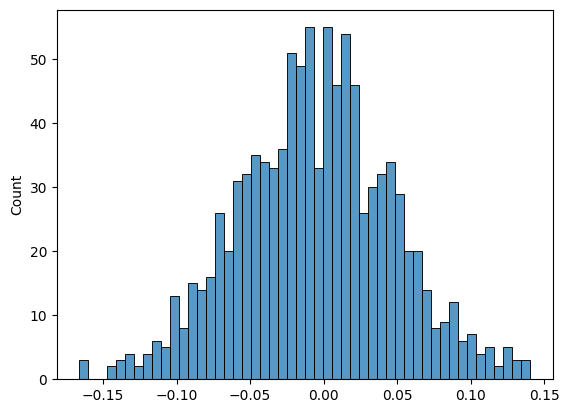

In [109]:
posterior_samples = guide.sample_posterior(
    jax.random.key(0), svi_result.params, sample_shape=(10000,)
)

priors = construct_normal_prior(posterior_samples)
bmlp_priors = {
    name.split("/")[1]: prior
    for name, prior in priors.items()
    if name.startswith("MLP/")
}

model = make_bmlp_model(prior=bmlp_priors, use_bayesian=True)
key, k1, k2 = jax.random.split(key, 3)
model_trace = handlers.trace(handlers.seed(model, k1)).get_trace(x_test)
d = model_trace["MLP/Dense_1.kernel"]["fn"].sample(k2, sample_shape=(1000,))
d = d.reshape(1000, -1)
sns.histplot(d[:, 1], bins=50)

## Optimization problem

After the inference to construct an predictive model, we want to create a new model with the optimized parameters as a priors. The model can be used in another model fitting process, and to hide the parameters from the inference process, we can use `handlers.block` to block the parameters from other handlers.

In [110]:
def make_optimal_control_model(priors):
    bmlp_priors = {
        name.split("/")[1]: prior
        for name, prior in priors.items()
        if name.startswith("MLP/")
    }

    model = make_bmlp_model(
        prior=bmlp_priors,
        sigma_prior=priors["sigma"],
        use_bayesian=True,
    )

    def optimal_control_model(y: jnp.ndarray | None = None):
        # param = numpyro.sample("param", dist.TruncatedNormal(0, .1, low=-1.5, high=1.5), sample_shape=(1,))
        param = numpyro.sample("param", dist.Normal(0, 0.1), sample_shape=(1,))

        assert isinstance(param, jnp.ndarray)

        # This is how we use pre-train model to predict the output
        key = numpyro.prng_key()
        with handlers.block(), handlers.seed(rng_seed=key):
            # Within this block, SVI will not be able to see the parameters within this block
            y_pred = model(param)

        return numpyro.sample("obs", dist.Normal(y_pred, 1), obs=y)  # type: ignore

    return optimal_control_model

In [111]:
key = jax.random.key(0)
# This is how we define the target value, we have to define it as a distribution
ans = 0.5
# y = 0.25 * jax.random.normal(key, shape=(1000,)) + ans
y = dist.Normal(ans, std).sample(key, sample_shape=(1000,))

optimal_problem = make_optimal_control_model(priors=priors)

optimizer = numpyro.optim.Minimize()
optimal_control_guide = autoguide.AutoLaplaceApproximation(optimal_problem)

svi = SVI(optimal_problem, optimal_control_guide, optimizer, loss=TraceMeanField_ELBO())
init_state = svi.init(jax.random.key(0), y)
optimal_state, loss = svi.update(init_state, y)
params = svi.get_params(optimal_state)

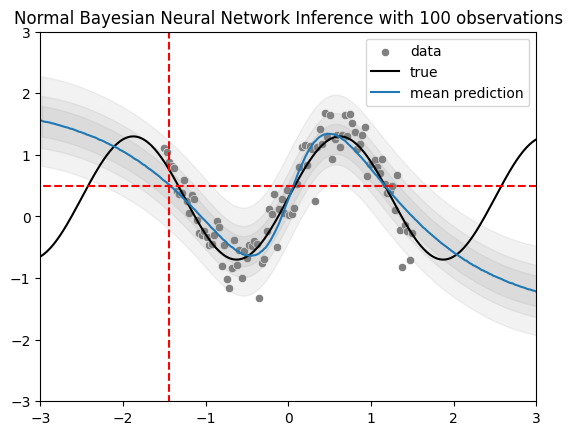

In [112]:
fig, ax = plot_data()
plot_bnn(ax)

ax.vlines(x=params["auto_loc"], ymin=-4, ymax=4, color="red", linestyles="dashed")
ax.hlines(y=ans, xmin=-4, xmax=4, color="red", linestyles="dashed")

## Two ways to predict with pre-trained model

### (1). Make a new model with priors!

In [113]:
def predictive_model(param, key, model):
    return handlers.seed(model, key)(param)

<Axes: ylabel='Count'>

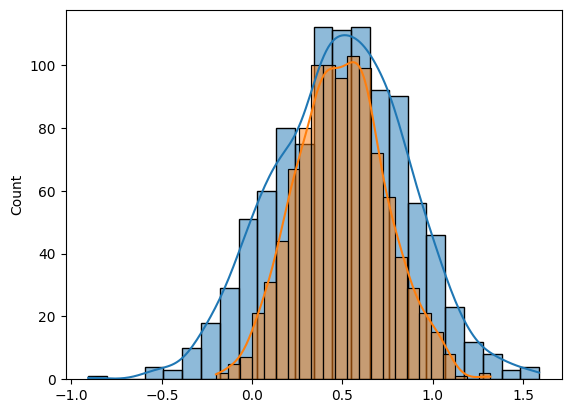

In [114]:
bmlp_priors = {
    name.split("/")[1]: prior
    for name, prior in priors.items()
    if name.startswith("MLP/")
}

model = make_bmlp_model(
    prior=bmlp_priors,
    sigma_prior=priors["sigma"],
    use_bayesian=True,
)

samples = jax.vmap(predictive_model, in_axes=(None, 0, None))(
    params["auto_loc"], jax.random.split(key, 1000), model
)

sns.histplot(np.asarray(samples), kde=True, label="posterior")
sns.histplot(np.asarray(y), kde=True, label="data")

### (2). Using the `numpyro` way

This is a simple way to make a prediction, but it cannot be used for the optimization.

<Axes: ylabel='Count'>

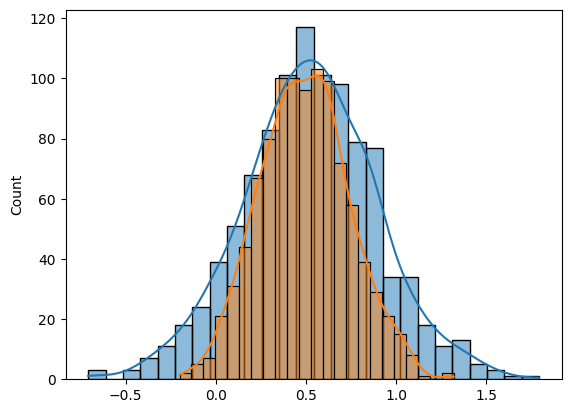

In [115]:
key, subkey = jax.random.split(key)
samples = Predictive(
    make_bmlp_model(use_bayesian=True),
    guide=guide,
    params=svi_result.params,
    num_samples=1000,
)(subkey, x=params["auto_loc"].reshape(1, -1))["y"]

sns.histplot(np.asarray(samples).reshape(-1), kde=True)
sns.histplot(np.asarray(y), kde=True, label="data")

## Evaluate the model performance

In [116]:
def mse(y_pred, y_test):
    return jnp.square(y_pred - y_test)

In [117]:
key, subkey = jax.random.split(key)
samples = Predictive(
    make_bmlp_model(use_bayesian=True),
    guide=guide,
    params=svi_result.params,
    num_samples=1000,
)(subkey, x=x_range.reshape(-1, 1))["y"]

samples.shape

(1000, 100)

In [118]:
mse(jnp.mean(samples, axis=0), y_noise).mean()

Array(0.1056215, dtype=float64)

In [119]:
jax.vmap(mse, in_axes=(0, None))(samples, y_noise).mean()

Array(0.23924608, dtype=float64)

In [120]:
mse(true_fn(x_range), y_noise).mean()

Array(0.07501917, dtype=float64)

In [103]:
std**2

0.0625

In [126]:
mock_samples = jax.vmap(noise_fn, in_axes=(None, 0))(
    x_range, jax.random.split(key, 10000)
)
(
    mse(jnp.mean(mock_samples, axis=0), y_noise).mean(),
    jax.vmap(mse, in_axes=(0, None))(mock_samples, y_noise).mean(),
)

(Array(0.07507949, dtype=float64), Array(0.13751766, dtype=float64))